/home/hausemaster/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


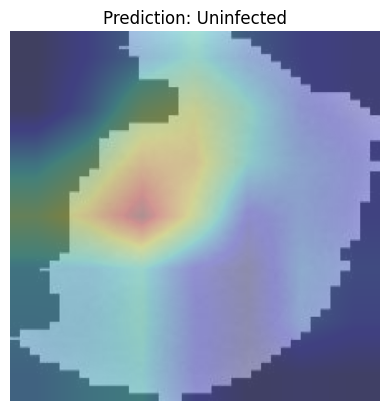

Prediction: Uninfected (Probability: 0.08884911984205246)


In [2]:
import cv2
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Load a pretrained ResNet50 model for feature extraction
def load_resnet50():
    model = torchvision.models.resnet50(pretrained=True)
    model.eval()  # Set model to evaluation mode
    return model

# Grad-CAM class definition
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for forward activations
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output)
        self.model.zero_grad()
        output[:, target_class].backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        weights = np.mean(gradients, axis=(2, 3))
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Preprocess the image and extract features using ResNet50
def preprocess_and_extract_features(image_path, model, device):
    # Preprocess the image for ResNet50 (224x224 and normalization)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet50 normalization
    ])
    
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Extract features using ResNet50 (we remove the last fully connected layer for feature extraction)
    with torch.no_grad():
        features = model.conv1(image_tensor)
        features = model.bn1(features)
        features = model.relu(features)
        features = model.maxpool(features)
        
        features = model.layer1(features)
        features = model.layer2(features)
        features = model.layer3(features)
        features = model.layer4(features)
        
        # Global Average Pooling
        features = features.mean([2, 3]).view(features.size(0), -1)
    
    # Convert features to numpy array (flattened for use in XGBoost)
    features = features.cpu().numpy()
    return features, image_tensor

# Load the XGBoost model
def load_xgboost_model(model_path):
    model = xgb.Booster()  # Initialize the XGBoost Booster
    model.load_model(model_path)  # Load the model from file
    return model

# Predict with the XGBoost model using extracted features
def predict_with_xgboost(model, image_path, resnet_model, gradcam, device):
    try:
        features, image_tensor = preprocess_and_extract_features(image_path, resnet_model, device)  # Extract features from the image using ResNet
    except ValueError as e:
        print(str(e))
        return None, None, None
    
    # Create DMatrix for XGBoost prediction
    dmatrix = xgb.DMatrix(features)
    prediction = model.predict(dmatrix)  # Make prediction using XGBoost
    predicted_label = "Infected" if prediction[0] == 1 else "Uninfected"  # Assuming binary classification
    
    # Generate Grad-CAM heatmap
    cam = gradcam.generate_cam(image_tensor)  # Generate Grad-CAM for the input image
    
    # Visualize the Grad-CAM heatmap
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay heatmap on image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, alpha=0.5)
    plt.title(f"Prediction: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label, prediction, cam

# Example usage
if __name__ == "__main__":
    # Set device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the XGBoost model
    model_path = "xgboost_cancer_model.json"  # Path to your saved XGBoost model
    model = load_xgboost_model(model_path)

    # Load ResNet50 for feature extraction
    resnet_model = load_resnet50()
    resnet_model.to(device)  # Move ResNet50 to the appropriate device

    # Initialize Grad-CAM for ResNet50 (using the last convolutional layer for Grad-CAM)
    target_layer = resnet_model.layer4[2].conv3  # Last convolutional layer in ResNet50 (you can change this to experiment)
    gradcam = GradCAM(resnet_model, target_layer)

    # Example image path
    image_path = "Demo/Uinf/a.jpg"  # Path to the image you want to classify

    # Predict with the XGBoost model using features extracted from ResNet50 and visualize Grad-CAM
    predicted_label, prediction, cam = predict_with_xgboost(model, image_path, resnet_model, gradcam, device)
    if predicted_label is not None:
        print(f"Prediction: {predicted_label} (Probability: {prediction[0]})")
